In [6]:
import os
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def highlight_min(row, column_index):
    styles = []
    for col in row.index:
        top_level = col[0]  
        # print(top_level)
        if top_level == 'MSE':
            max_value = row[column_index.get_loc(top_level)].min()
            second_value = row[column_index.get_loc(top_level)].nsmallest(2).iloc[-1]
            third_value = row[column_index.get_loc(top_level)].nsmallest(3).iloc[-1]
        elif top_level == 'R2':
            max_value = row[column_index.get_loc(top_level)].max()
            second_value = row[column_index.get_loc(top_level)].nlargest(2).iloc[-1]
            third_value = row[column_index.get_loc(top_level)].nlargest(3).iloc[-1]
        style = ''
        if row[col] == max_value:
            # style = 'background-color: #e3867f'
            style = 'background-color: #cfb04a'
        elif row[col] == second_value:
            style = 'background-color: #dbd6c5; color: #333333'
        elif row[col] == third_value:
            style = 'background-color: #785e08'
        styles.append(style)
    return styles

def show_regression_results(label: str, source_df: pd.DataFrame):
    print(f'{label}:')
    means = source_df.mean()
    means_df = means.to_frame().T
    styled_mean_df = means_df.style.apply(
        highlight_min, axis=1, column_index=means_df.columns
    )
    display(styled_mean_df)

In [8]:
def visualize_AB_response_correlation(title, y_A, y_B):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(title)
    ax[0].scatter(y_A, y_B, alpha=0.5)
    ax[0].set_xlabel("y_A")
    ax[0].set_ylabel("y_B")
    ax[0].set_title("Зависимость y_B от y_A")

    ax[1].hist(y_B, bins=30)
    ax[1].set_title("Распределение y_B")
    
    plt.show()

def test_correlation(dataset: list[tuple[str]]):
    print(dataset)
    for title, mkf, mkA, mkB in dataset:
        X, y = mkf()
        y_A = mkA(y)
        y_B = mkB(X, y, y_A)
        visualize_AB_response_correlation(title, y_A, y_B)

## Синтетические данные

### Функции данных и откликов

In [9]:
def generate_regression_spiral(n_samples=400, n_dims=2, noise=0.5, random_state=42):
    np.random.seed(random_state)
    t = np.linspace(0, 3 * 2 * np.pi, n_samples)  # 3 полных оборота
    x = t * np.cos(t) + np.random.normal(0, noise, n_samples)
    y = t * np.sin(t) + np.random.normal(0, noise, n_samples)
    X = np.vstack([x, y]).T
    return X, t

def generate_target_A(t: np.ndarray):
    return np.sin(t) + 0.1 * t

def generate_target_A_linear(t: np.ndarray):
    return 3 * t

def generate_target_A_pow(t: np.ndarray, pow=3):
    return t ** pow

def generate_target_B(X: np.ndarray, t, target_A: np.ndarray):
    radius = np.sqrt(X[:,0]**2 + X[:,1]**2)
    return 0.5 * target_A + 0.3 * radius**2 + np.random.normal(0, 0.1, len(X))

def generate_target_B_complex(X: np.ndarray, t, target_A: np.ndarray):
    n_features = X.shape[1]
    noise = np.random.normal(0, 0.1, len(X))
    y_B = 5 * target_A
    if n_features >= 2:
        y_B += 10 * np.sin(np.pi * X[:,0] * X[:,1])
    if n_features >= 3:
        y_B += 20 * (X[:,2] - 0.5)**2 
    if n_features >= 4:
        y_B += 10 * np.abs(X[:,3])  
    if n_features >= 5:
        y_B += 5 * np.exp(X[:,4])
    return y_B + noise

In [13]:
def interpolate_two_points(p1: np.ndarray, p2: np.ndarray, n: int):
    x = np.linspace(p1[0], p2[0], n)
    y = np.linspace(p1[1], p2[1], n)
    return np.column_stack((x, y))

def generate_broken_spiral(
    n_samples=400,
    noise=0.5,
    random_state=42,
    directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
):
    
    np.random.seed(random_state)
    # directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]  # Право, вверх, лево, вниз
    X = []
    t = []
    cycles = 3
    pts_per_unit = int(np.ceil(n_samples * 1.0 / np.sum(2 * np.arange(1, 2 * cycles + 1))))
    segment_len = 0
    cur_t = 0
    cur_pos = np.array([0.0, 0.0])
    for i in range(cycles * 4):
        if i % 2 == 0:
            segment_len += 1
        cur_dir = directions[i % 4]
        pts_per_segment = pts_per_unit * segment_len
        segment_ts = np.linspace(cur_t, cur_t + np.pi / 2, pts_per_segment)
        
        segment_Xs = interpolate_two_points(
            np.array([0, 0]),
            np.array(cur_dir) * segment_len * 2 * np.pi,
            pts_per_segment
        ) + cur_pos
        cur_t += np.pi / 2
        cur_pos = segment_Xs[-1]
        for j in range(pts_per_segment):
            X.append(segment_Xs[j])
            t.append(segment_ts[j])
    X_ = np.array(X[:n_samples])
    print(X_.size, X_.shape)
    X_ = X_ + np.random.normal(0, noise, X_.size).reshape(X_.shape)
    return X_, np.array(t[:n_samples])


def generate_rotated_broken_spiral(
    n_samples=400,
    noise=0.5,
    random_state=42,
):
    pos = np.sqrt(2)/2
    neg = -pos
    return generate_broken_spiral(
        n_samples=n_samples,
        noise=noise,
        random_state=random_state,
        directions=[(pos, pos), (neg, pos), (neg, neg), (pos, neg)]
    )

def plot_spiral(X, values=None, title="Broken Spiral", cmap='viridis'):
    plt.figure(figsize=(8, 8))
    if values is not None:
        plt.scatter(X[:, 0], X[:, 1], c=values, cmap=cmap, s=20)
        plt.colorbar(label='Value')
    else:
        plt.scatter(X[:, 0], X[:, 1], c=np.arange(len(X)), cmap='viridis', s=20)
        plt.colorbar(label='Index')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis('equal')
    plt.grid()
    plt.show()

### Визуализация зависимости y_B от y_A

In [14]:
from itertools import product

data_options = [
    ('Spiral', generate_regression_spiral),
    # ('Broken Spiral', generate_broken_spiral),
    ('Rotated Spiral', generate_rotated_broken_spiral),
]
A_options = [
    ('Sin A', generate_target_A),
    ('Linear A', generate_target_A_linear),
    ('Pow A', generate_target_A_pow),
]
B_options = [
    ('Simple B', generate_target_B),
    ('Complex B', generate_target_B_complex),
]
datasets = list(product(data_options, A_options, B_options))

[('Spiral,Sin A,Simple B', <function generate_regression_spiral at 0x000001CB6913BC70>, <function generate_target_A at 0x000001CB6913B0A0>, <function generate_target_B at 0x000001CB6913B010>), ('Spiral,Sin A,Complex B', <function generate_regression_spiral at 0x000001CB6913BC70>, <function generate_target_A at 0x000001CB6913B0A0>, <function generate_target_B_complex at 0x000001CB6913BA30>), ('Spiral,Linear A,Simple B', <function generate_regression_spiral at 0x000001CB6913BC70>, <function generate_target_A_linear at 0x000001CB6913A680>, <function generate_target_B at 0x000001CB6913B010>), ('Spiral,Linear A,Complex B', <function generate_regression_spiral at 0x000001CB6913BC70>, <function generate_target_A_linear at 0x000001CB6913A680>, <function generate_target_B_complex at 0x000001CB6913BA30>), ('Spiral,Pow A,Simple B', <function generate_regression_spiral at 0x000001CB6913BC70>, <function generate_target_A_pow at 0x000001CB6913AF80>, <function generate_target_B at 0x000001CB6913B010>

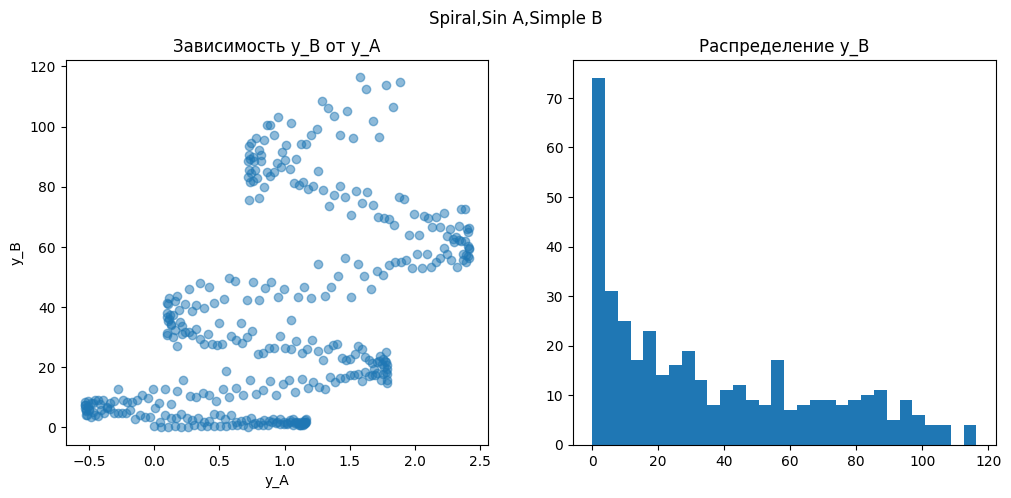

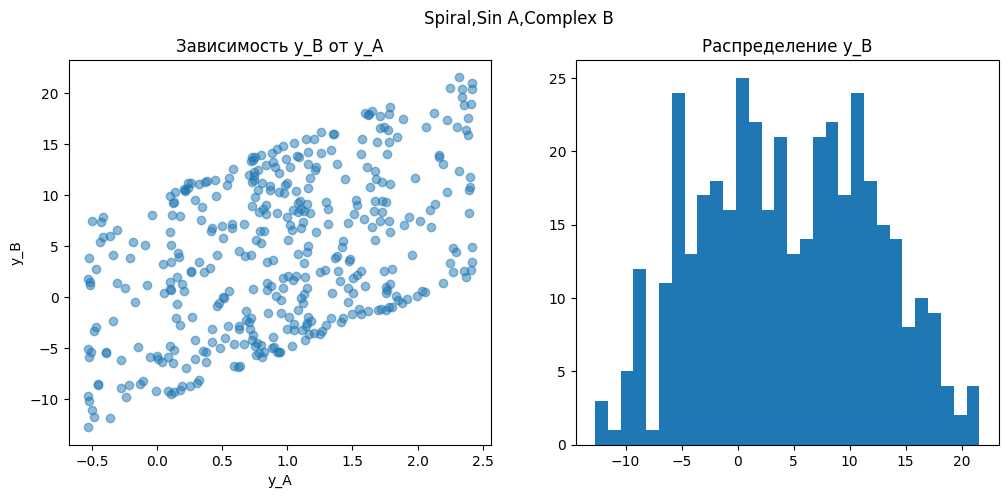

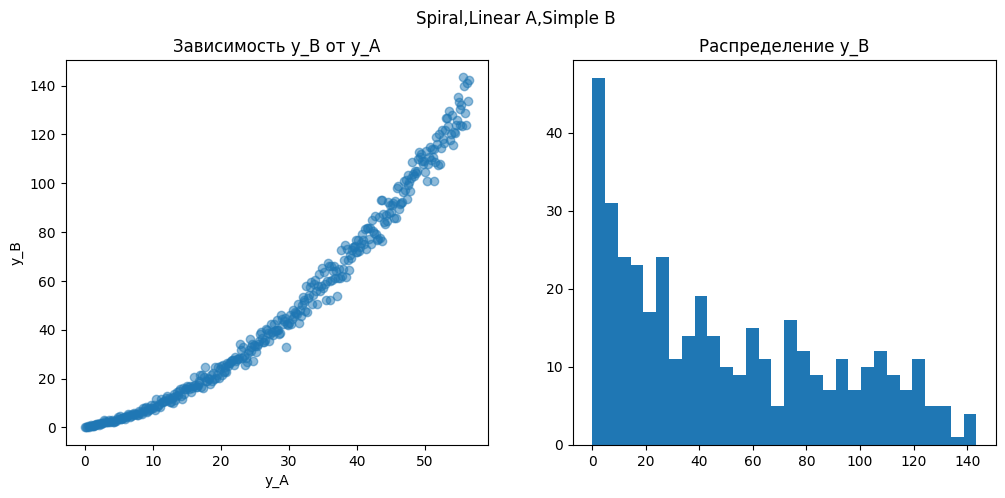

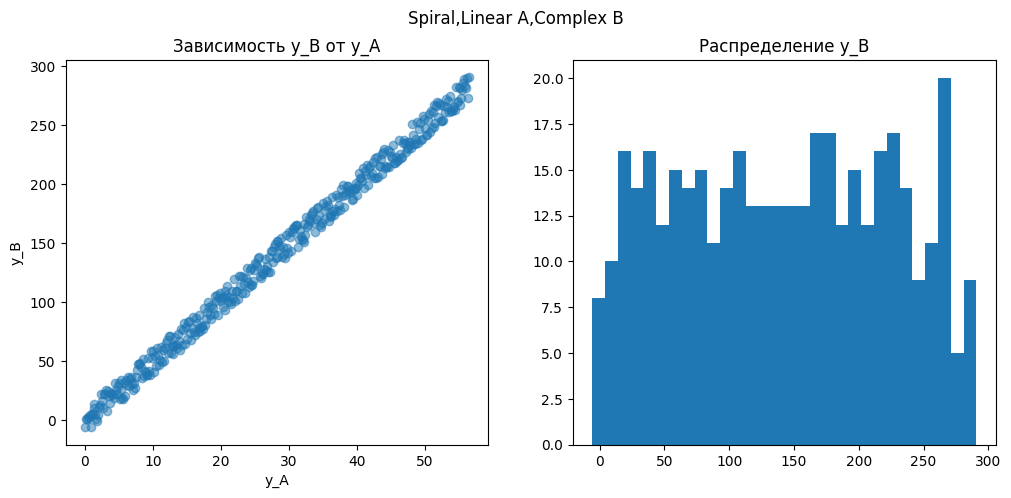

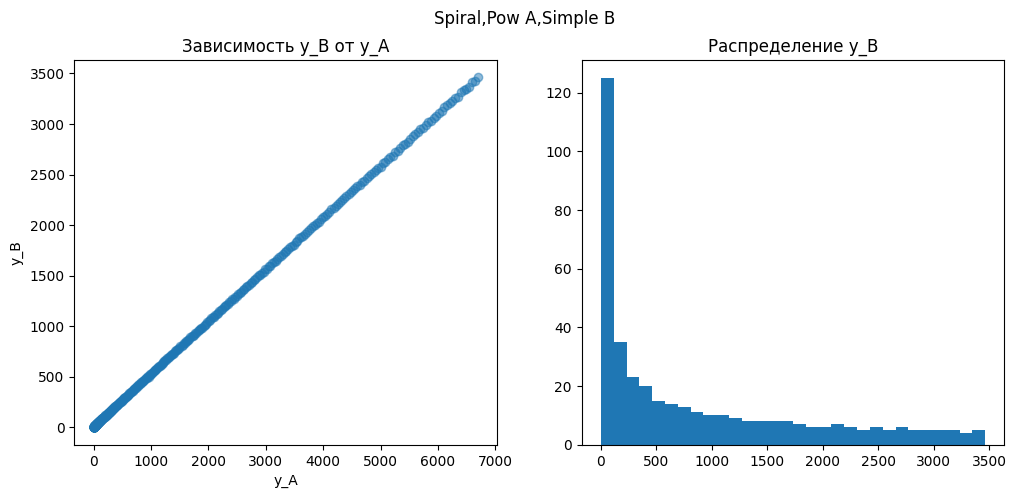

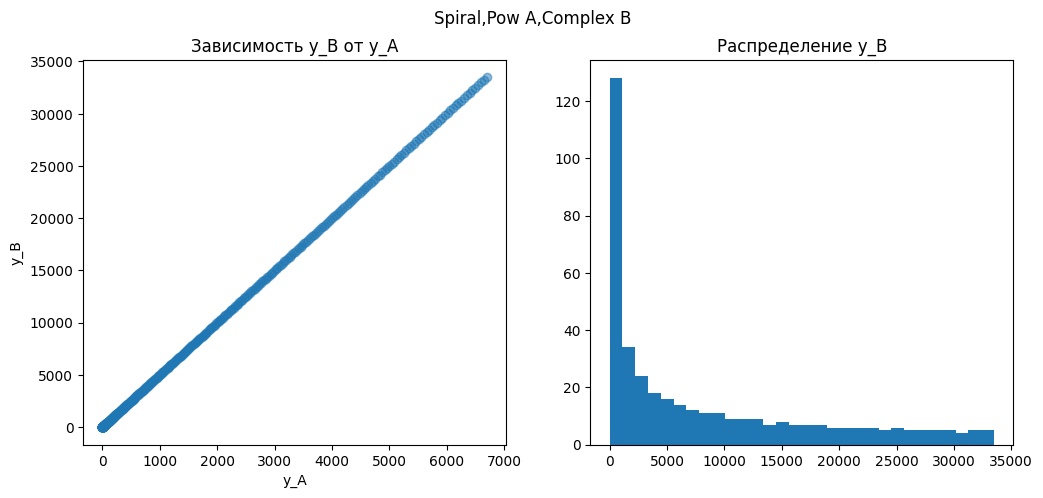

800 (400, 2)


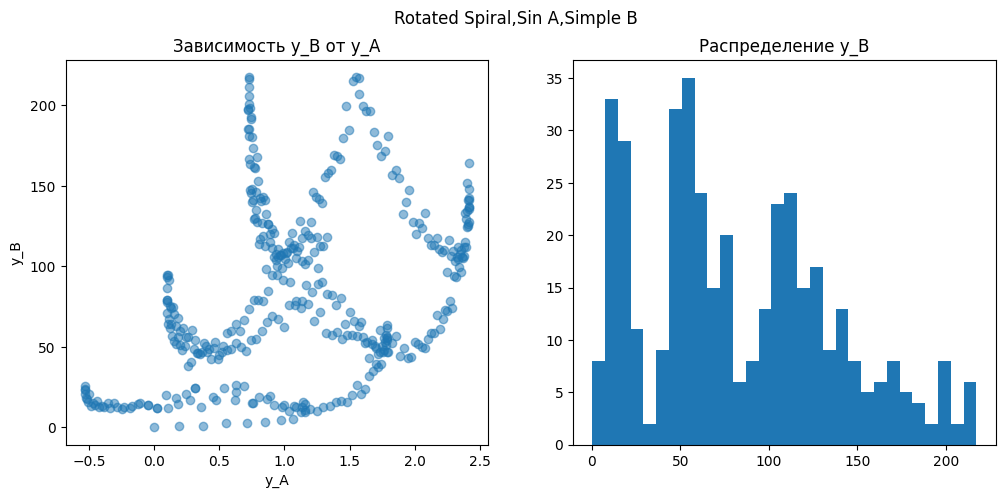

800 (400, 2)


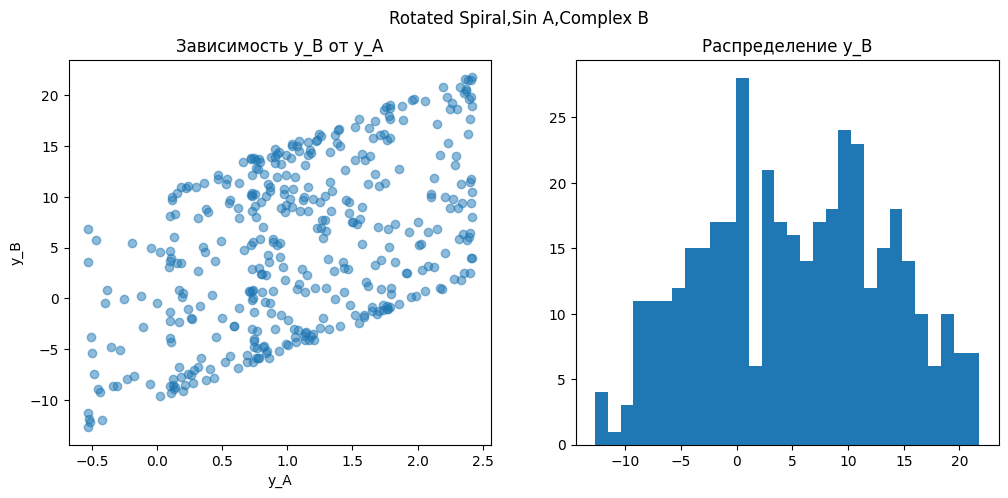

800 (400, 2)


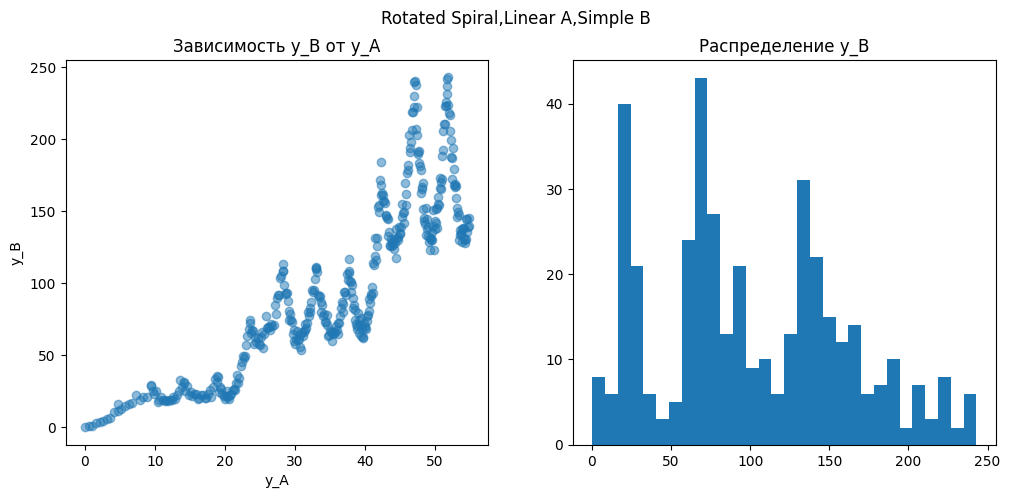

800 (400, 2)


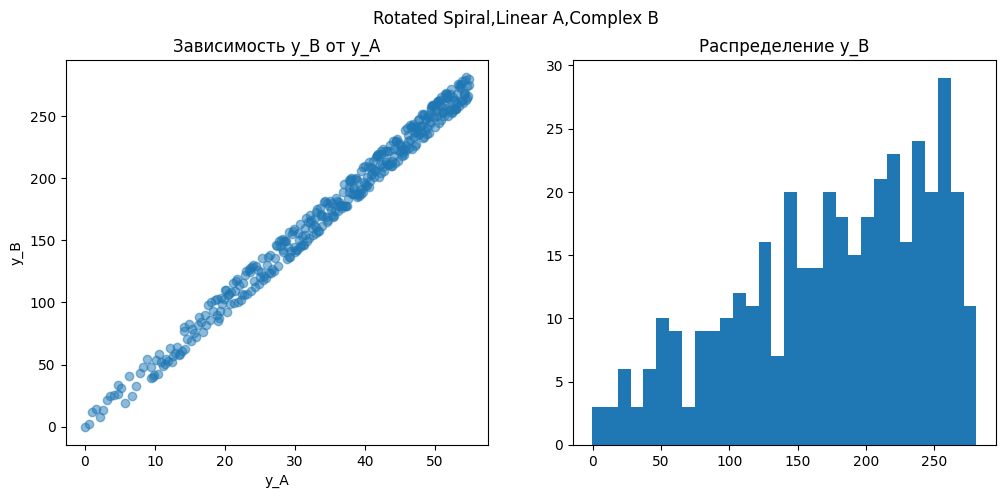

800 (400, 2)


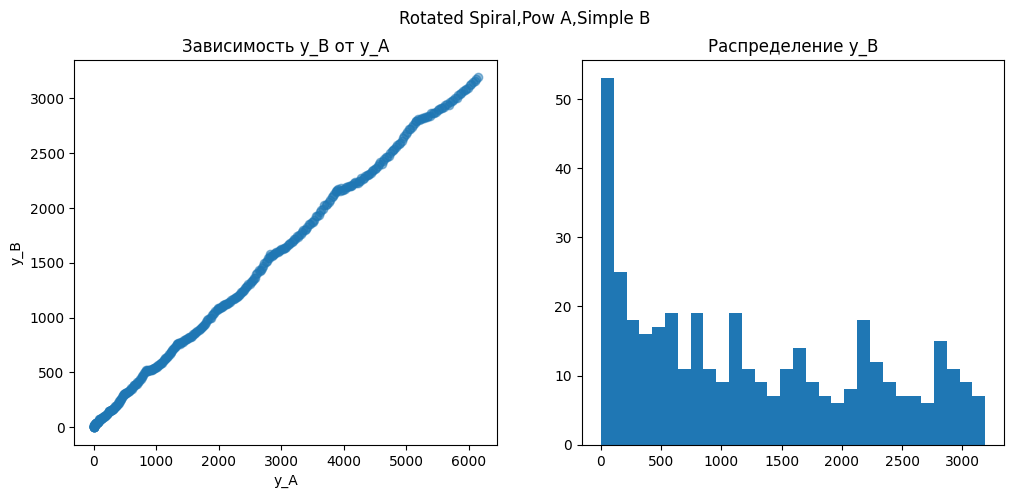

800 (400, 2)


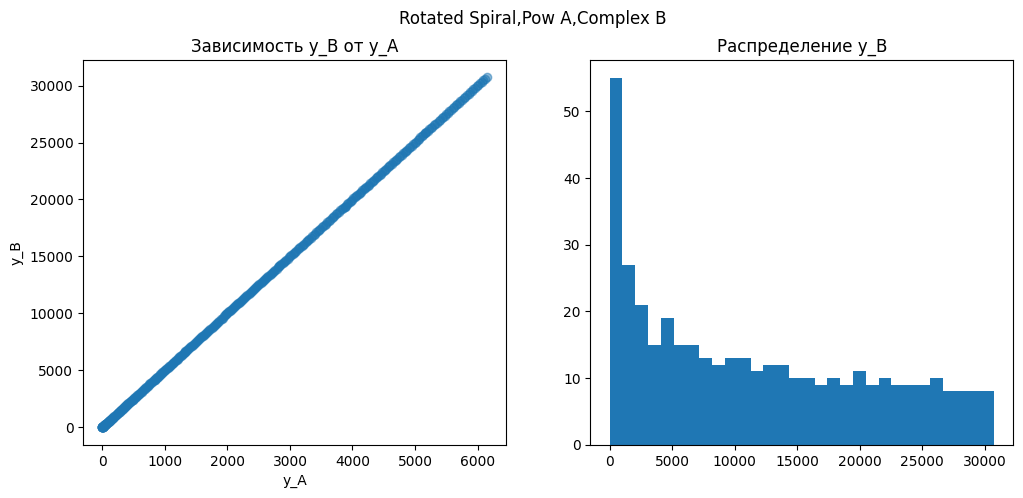

In [15]:
visualized = []
for (d_name, d_gen), (A_name, A_gen), (B_name, B_gen) in datasets:
    label = ','.join([d_name, A_name, B_name])
    visualized.append((label, d_gen, A_gen, B_gen))
test_correlation(visualized)

### Результаты

In [16]:
folder = './transfer_regression'
for file in os.listdir(folder):
    if file.endswith('_squared.csv'):
        name = file.split('.')[0].split('_')[0]
        df = pd.read_csv(Path(folder) / file, header=[0, 1])
        show_regression_results(name, df)

Rotated Spiral,Linear A,Complex B:


Rotated Spiral,Linear A,Simple B:


Rotated Spiral,Pow A,Complex B:


Rotated Spiral,Pow A,Simple B:


Rotated Spiral,Sin A,Complex B:


Rotated Spiral,Sin A,Simple B:


Spiral,Linear A,Complex B:


Spiral,Linear A,Simple B:


Spiral,Pow A,Complex B:


Spiral,Pow A,Simple B:


Spiral,Sin A,Complex B:


Spiral,Sin A,Simple B:


## Friedman 1,2,3

### Функции данных и откликов

In [17]:
from sklearn.datasets import make_friedman1, make_friedman2, make_friedman3


NOISE = 0.5
def mk_friedman1(n_samples=450):
    return make_friedman1(n_samples, noise=NOISE, random_state=42)

def friedman1_y_A(y_f1):
    return y_f1

def friedman1_y_A_shift(y_f1):
    return y_f1 + 5.0

def friedman1_y_A_pure(y_f1):
    return y_f1

def friedman1_y_B(X, t, y_A):
    return 0.5*y_A + 10*np.sin(np.pi*X[:,0]*X[:,1]) + 20*(X[:,2]-0.5)**2 + np.random.normal(0, NOISE, len(X))

def friedman1_y_B_pure(X, y_f1, y_A):
    return y_f1 ** 2 + np.random.normal(0, NOISE, len(y_f1))

def friedman1_y_B_shift(X, y_f1, y_A):
    return y_f1 + 10.0 + np.random.normal(0, 0.1 * NOISE, len(y_f1))

def mk_friedman2(n_samples=450):
    return make_friedman2(n_samples, noise=NOISE, random_state=42)

def friedman2_y_A(y_f2):
    return np.sqrt(y_f2)

def friedman2_y_A_pure(y_f2):
    return np.sqrt(y_f2)

def friedman2_y_B(X, t, y_A):
    return 0.5*y_A + np.sqrt(X[:,0]**2 + (X[:,1]*X[:,2] - 1/(X[:,1]*X[:,3]))**2) + np.random.normal(0, NOISE, len(X))

def friedman2_y_B_pure(X, y_f2, y_A):
    return np.log(y_f2) + np.random.normal(0, NOISE * 0.5, len(y_f2))

def friedman2_1_y_A(y_f2):
    y_A = np.log(1 + y_f2)
    return (y_A - y_A.mean()) / y_A.std()

def friedman2_1_y_B(X, t, y_A):
    term1 = 0.3 * y_A**2  
    term2 = np.sqrt(X[:,0]**2 + (X[:,1]*X[:,2] - 1/(X[:,1]*X[:,3]))**2)
    term3 = 5 * np.sin(2*np.pi*X[:,0])  
    y_B = term1 + term2 + term3
    return (y_B - y_B.mean()) / y_B.std() + np.random.normal(0, NOISE, len(X))

def mk_friedman3(n_samples=450):
    return make_friedman3(n_samples, noise=NOISE, random_state=42)

def friedman3_y_A(y_f3):
    return 0.8*y_f3 + 0.2*np.random.normal(0, 0.1, len(y_f3))

def friedman3_y_A_pure(y_f3):
    return y_f3 * 0.5

def friedman3_y_A_shift(y_f3):
    return y_f3 * 0.5 + 5

def friedman3_y_B(X, t, y_A):
    return 0.5*y_A + np.arctan((X[:,1]*X[:,2] - 1/(X[:,1]*X[:,3])) / X[:,0]) + np.random.normal(0, 0.1, len(X))

def friedman3_y_B_pure(X, y_f3, y_A):
    return y_f3 ** 3 + np.sin(y_f3) + 0.2*np.random.normal(0, NOISE, len(y_f3))

def friedman3_y_B_xlogx(X, y_f3, y_A):
    return y_f3 * np.log(1 + y_f3) + np.random.normal(0, NOISE, len(y_f3))

### Визуализация зависимости y_B от y_A

In [18]:
friedmen = [
    ('Friedman 1', mk_friedman1, friedman1_y_A, friedman1_y_B),
    ('Friedman 2', mk_friedman2, friedman2_y_A, friedman2_y_B),
    ('Friedman 2.1', mk_friedman2, friedman2_1_y_A, friedman2_1_y_B),
    ('Friedman 3',mk_friedman3, friedman3_y_A, friedman3_y_B),
]
# friedmen

[('Friedman 1', <function mk_friedman1 at 0x000001CB69139F30>, <function friedman1_y_A at 0x000001CB66561CF0>, <function friedman1_y_B at 0x000001CB665620E0>), ('Friedman 2', <function mk_friedman2 at 0x000001CB66562290>, <function friedman2_y_A at 0x000001CB66562320>, <function friedman2_y_B at 0x000001CB66562440>), ('Friedman 2.1', <function mk_friedman2 at 0x000001CB66562290>, <function friedman2_1_y_A at 0x000001CB66562560>, <function friedman2_1_y_B at 0x000001CB665625F0>), ('Friedman 3', <function mk_friedman3 at 0x000001CB66562680>, <function friedman3_y_A at 0x000001CB66562710>, <function friedman3_y_B at 0x000001CB665628C0>)]


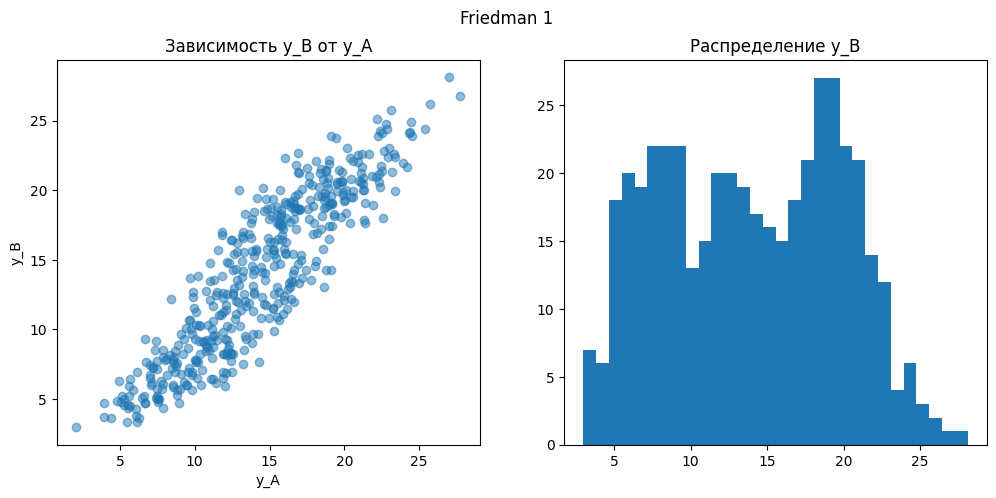

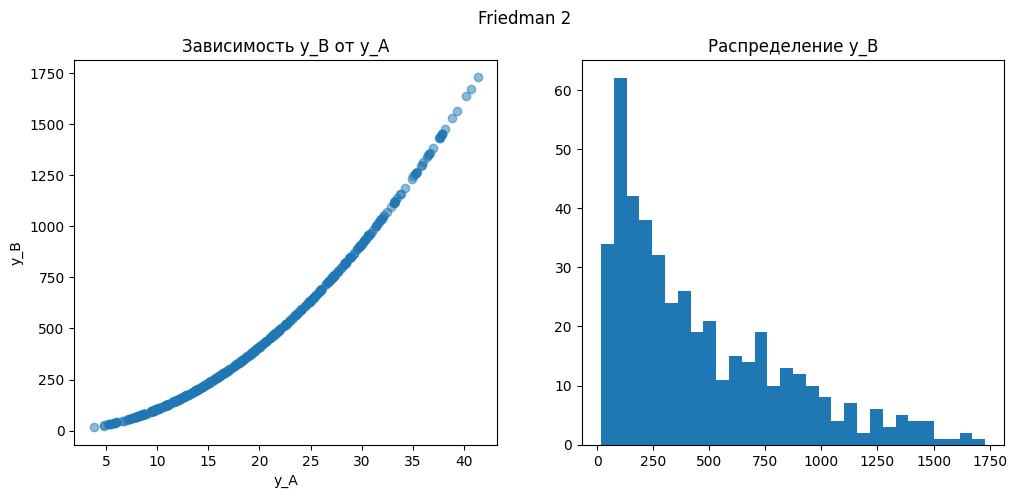

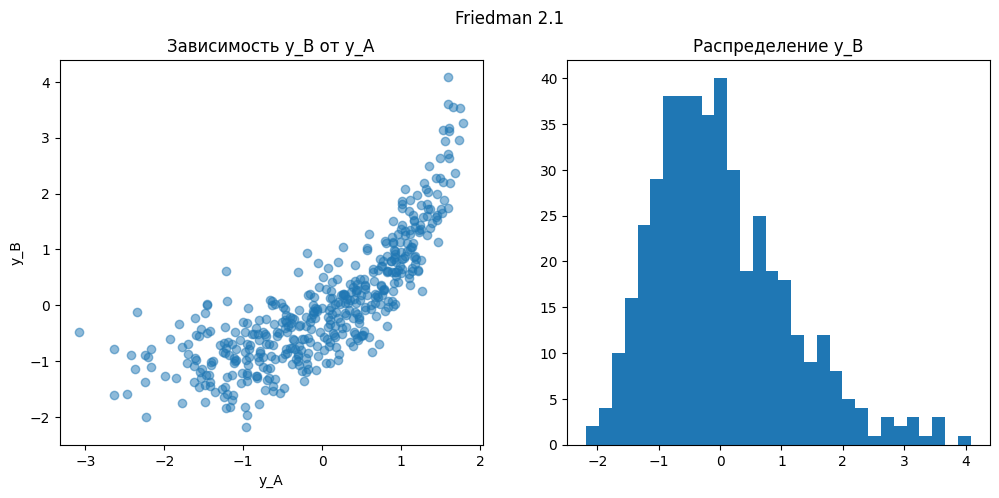

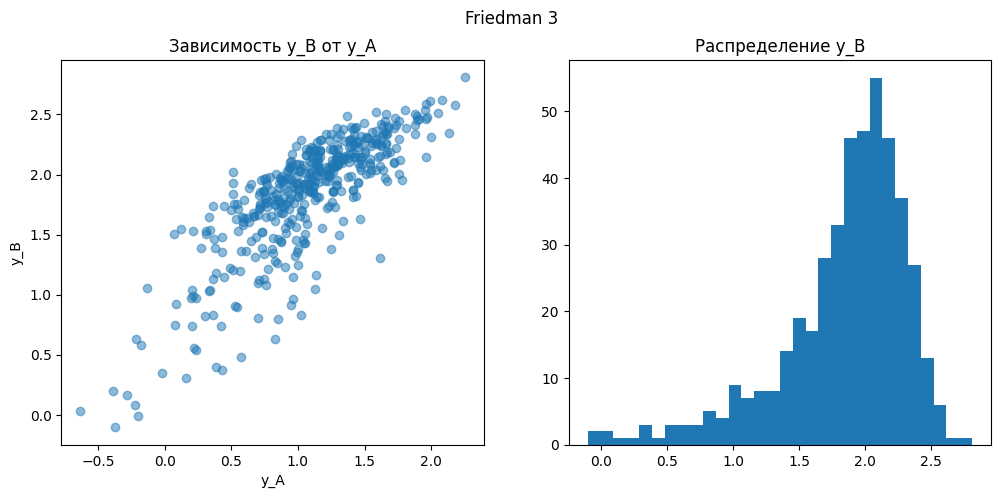

In [19]:
test_correlation(dataset=friedmen)

### Результаты

In [38]:
for file in os.listdir(folder):
    if file.startswith('Friedman'):
        name = file.split('.')[0].split('_')[0]
        df = pd.read_csv(Path(folder) / file, header=[0, 1])
        show_regression_results(name, df)

Friedman 1:


Friedman 2:


Friedman 2:


Friedman 3:


### Более простые зависимости

In [21]:
simple_friedmen = [
    ('Simple Friedman 1', mk_friedman1, friedman1_y_A_pure, friedman1_y_B_pure),
    ('Shift Friedman 1', mk_friedman1, friedman1_y_A_shift, friedman1_y_B_shift),
    ('Simple Friedman 2', mk_friedman2, friedman2_y_A_pure, friedman2_y_B_pure),
    ('Simple Friedman 3', mk_friedman3, friedman3_y_A_pure, friedman3_y_B_pure),
    ('Simple Friedman 3 xlogx', mk_friedman3, friedman3_y_A_shift, friedman3_y_B_xlogx),
]

[('Simple Friedman 1', <function mk_friedman1 at 0x000001CB69139F30>, <function friedman1_y_A_pure at 0x000001CB66562050>, <function friedman1_y_B_pure at 0x000001CB66562170>), ('Shift Friedman 1', <function mk_friedman1 at 0x000001CB69139F30>, <function friedman1_y_A_shift at 0x000001CB66561FC0>, <function friedman1_y_B_shift at 0x000001CB66562200>), ('Simple Friedman 2', <function mk_friedman2 at 0x000001CB66562290>, <function friedman2_y_A_pure at 0x000001CB665623B0>, <function friedman2_y_B_pure at 0x000001CB665624D0>), ('Simple Friedman 3', <function mk_friedman3 at 0x000001CB66562680>, <function friedman3_y_A_pure at 0x000001CB665627A0>, <function friedman3_y_B_pure at 0x000001CB66562950>), ('Simple Friedman 3 xlogx', <function mk_friedman3 at 0x000001CB66562680>, <function friedman3_y_A_shift at 0x000001CB66562830>, <function friedman3_y_B_xlogx at 0x000001CB665629E0>)]


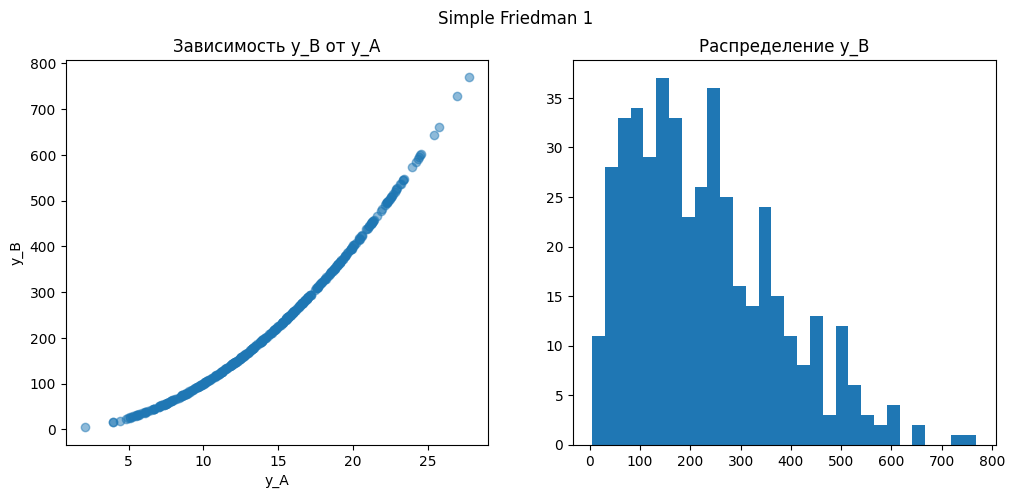

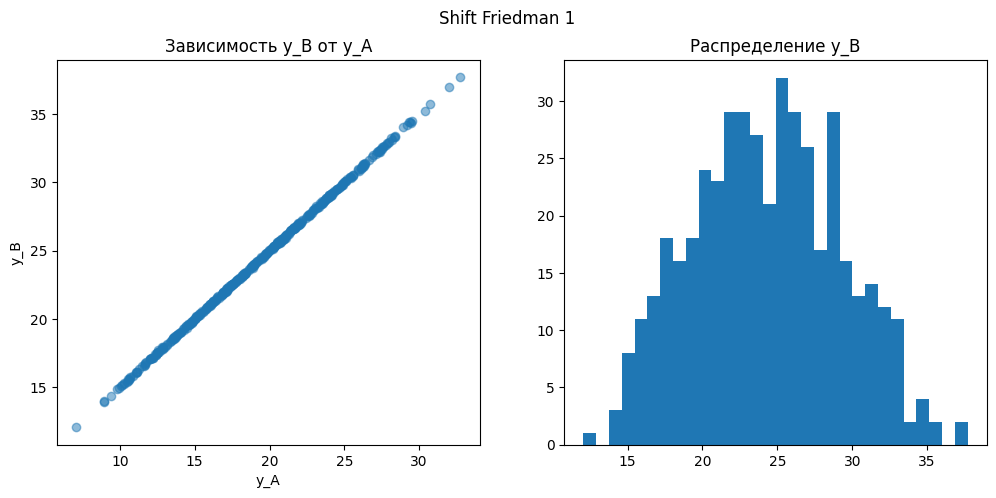

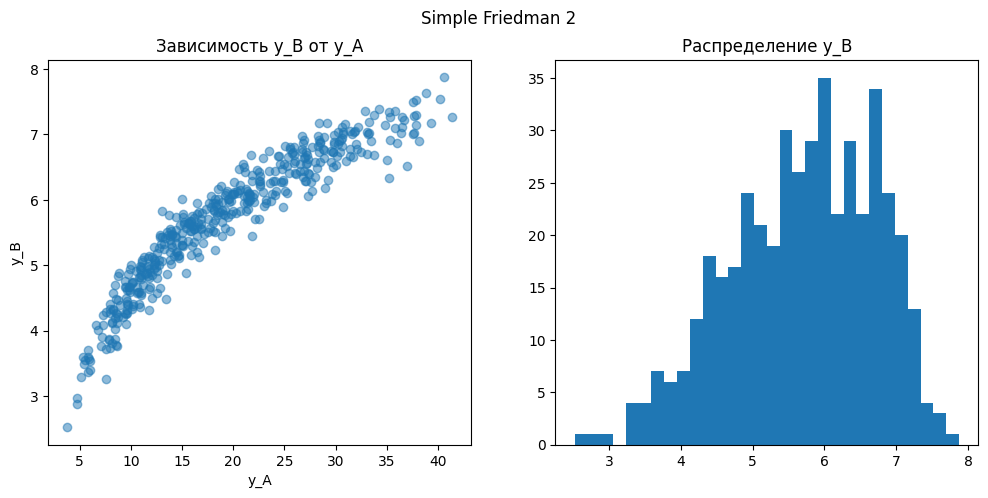

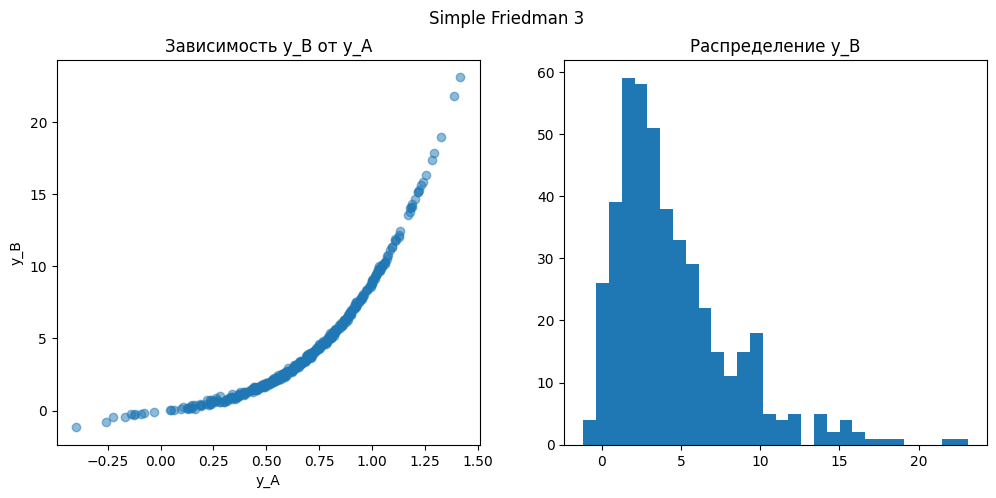

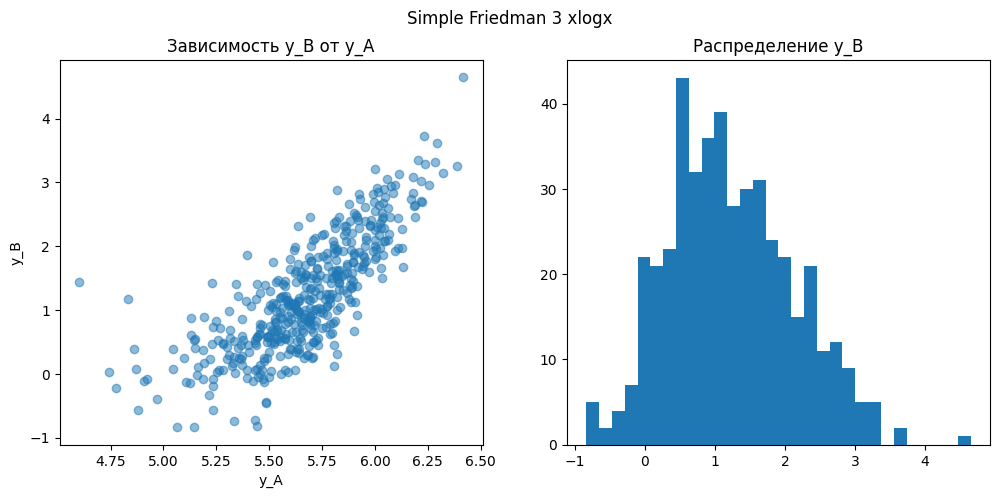

In [22]:
test_correlation(dataset=simple_friedmen)

In [23]:
for file in os.listdir(folder):
    if file.startswith(('Simple Friedman', 'Shift Friedman')):
        name = file.split('.')[0].split('_')[0]
        df = pd.read_csv(Path(folder) / file, header=[0, 1])
        show_regression_results(name, df)

Shift Friedman 1:


Simple Friedman 1:


Simple Friedman 2:


Simple Friedman 3 xlogx:


Simple Friedman 3:


## Linnerud

### Функции данных и откликов

In [24]:
from sklearn.datasets import load_linnerud

data = load_linnerud()

def mk_linnerud():
    return data.data, data.target

def linnerud_y_A(y_l):
    return y_l[:, 0]

def linnerud_y_B_asA(y_l):
    return y_l[:, 1]

def linnerud_y_B(X, y_l, y_A):
    return y_l[:, 1]

def linnerud_y_C(X, y_l, y_A):
    return y_l[:, 2]

### Визуализация зависимости y_B от y_A

In [25]:
linneruds = [
    ('Linnerud AB', mk_linnerud, linnerud_y_A, linnerud_y_B),
    ('Linnerud AC', mk_linnerud, linnerud_y_A, linnerud_y_C),
    ('Linnerud BC', mk_linnerud, linnerud_y_B_asA, linnerud_y_C),
]

[('Linnerud AB', <function mk_linnerud at 0x000001CB7D145FC0>, <function linnerud_y_A at 0x000001CB7D1453F0>, <function linnerud_y_B at 0x000001CB7D144CA0>), ('Linnerud AC', <function mk_linnerud at 0x000001CB7D145FC0>, <function linnerud_y_A at 0x000001CB7D1453F0>, <function linnerud_y_C at 0x000001CB7D1440D0>), ('Linnerud BC', <function mk_linnerud at 0x000001CB7D145FC0>, <function linnerud_y_B_asA at 0x000001CB7D147AC0>, <function linnerud_y_C at 0x000001CB7D1440D0>)]


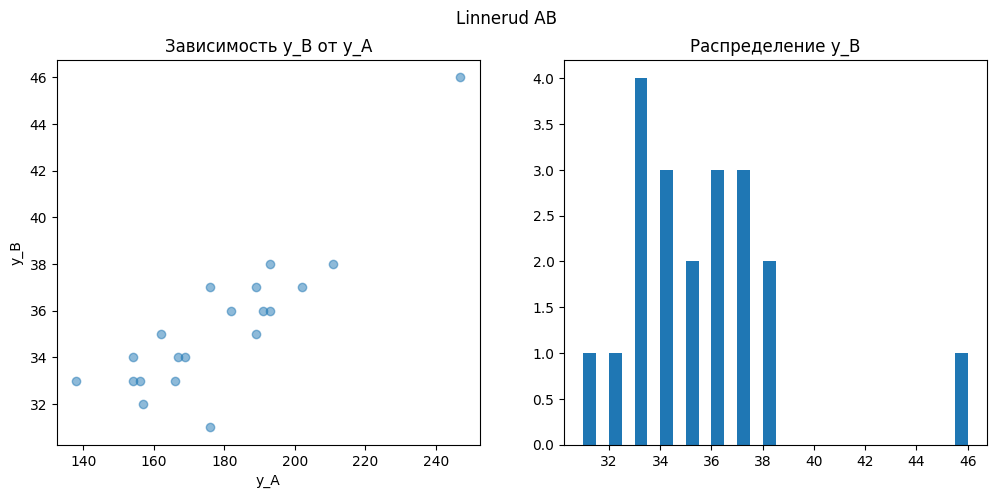

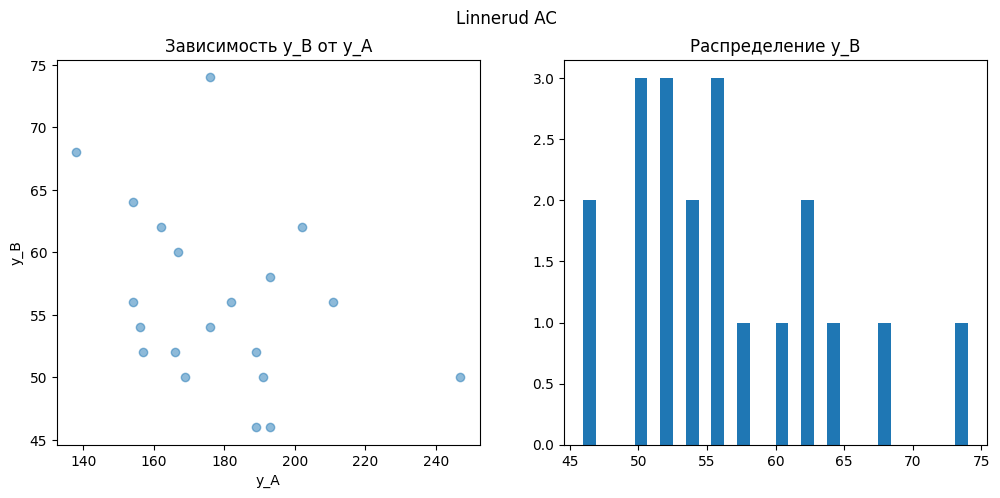

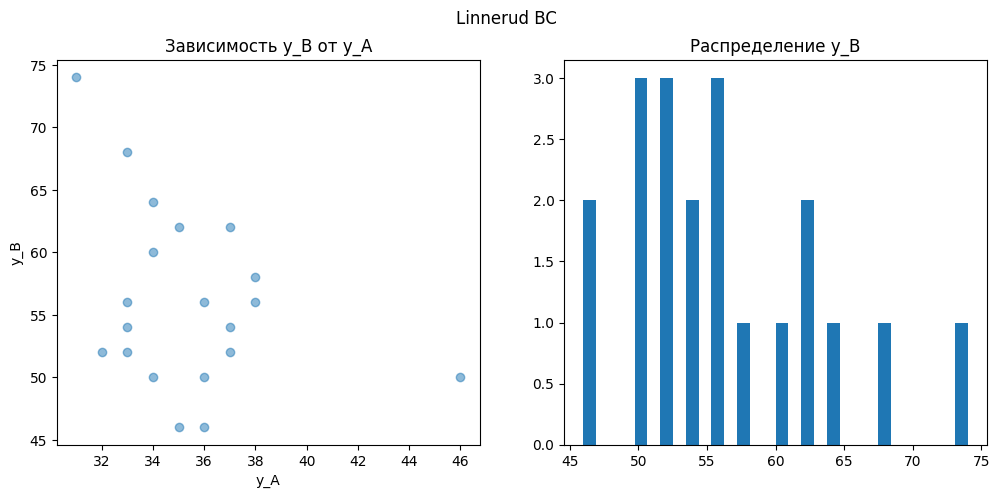

In [26]:
test_correlation(linneruds)

### Результаты

In [27]:
for file in os.listdir(folder):
    if file.startswith(('Linnerud')):
        name = file.split('.')[0].split('_')[0]
        df = pd.read_csv(Path(folder) / file, header=[0, 1])
        show_regression_results(name, df)

Linnerud AB:


Linnerud AC:


Linnerud BC:


## Make regression

### Функции данных и откликов

In [28]:
from sklearn.datasets import make_regression

MRX, MRy = make_regression(n_samples=450, n_features=10, n_targets=2)

def mk_mr():
    return MRX, MRy

def MR_y_A(y_mr):
    return y_mr[:, 0]

def MR_y_B(X, y_mr, y_A):
    return y_mr[:, 1]

### Визуализация зависимости y_B от y_A

[('Make regression', <function mk_mr at 0x000001CB7D275C60>, <function MR_y_A at 0x000001CB6CFC4700>, <function MR_y_B at 0x000001CB6CFC5000>)]


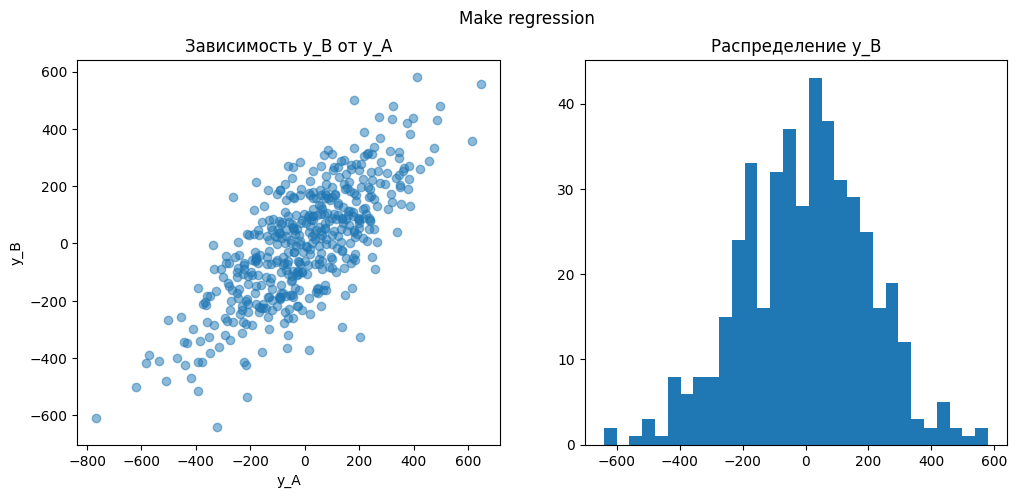

In [29]:
test_correlation([('Make regression', mk_mr, MR_y_A, MR_y_B)])

### Результаты

In [30]:
for file in os.listdir(folder):
    if file.startswith(('Make Regression')):
        name = file.split('.')[0].split('_')[0]
        df = pd.read_csv(Path(folder) / file, header=[0, 1])
        show_regression_results(name, df)

Make Regression:


## Кластеры

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.decomposition import PCA
import time

def generate_data(
    n_clusters=3, 
    n_features=2, 
    n_samples_per_cluster=100, 
    center_generation='circle', 
    max_radius=1.0,
    angle_range=(0, 180),
    random_state=None,
    response_range=(-3, 3),
    cov_scales=(0.1, 0.2),
):
    if random_state is not None:
        np.random.seed(random_state)
    else:
        np.random.seed(time.time_ns() % (2**16))
    
    # Генерация центров кластеров
    centers = np.zeros((n_clusters, n_features))
    if center_generation == 'circle':
        angles = np.linspace(0, 2*np.pi, n_clusters, endpoint=False)
        for i in range(n_clusters):
            centers[i, 0] = max_radius * np.cos(angles[i])
            centers[i, 1] = max_radius * np.sin(angles[i])
            if n_features > 2:
                centers[i, 2:] = np.random.normal(0, 0.05, n_features - 2)
    else:
        for i in range(n_clusters):
            radius = max_radius * np.sqrt(np.random.rand())
            angle = 2 * np.pi * np.random.rand()
            centers[i, 0] = radius * np.cos(angle)
            centers[i, 1] = radius * np.sin(angle)
            if n_features > 2:
                centers[i, 2:] = np.random.normal(0, 0.05, n_features - 2)
    
    # Генерация ковариационных матриц с произвольными углами
    covs = []
    thetas = np.random.uniform(
        np.radians(angle_range[0]),
        np.radians(angle_range[1]),
        n_clusters
    )
    scales = np.random.uniform(cov_scales[0], cov_scales[1], size=(n_clusters, 2))
    
    for i in range(n_clusters):
        theta = thetas[i]
        R = np.array([[np.cos(theta), -np.sin(theta)], 
                      [np.sin(theta), np.cos(theta)]])
        
        if n_features == 2:
            cov = R @ np.diag(scales[i]) @ R.T
        else:
            cov = np.eye(n_features)
            cov[:2, :2] = R @ np.diag(scales[i]) @ R.T
        covs.append(cov)
    
    X = []
    labels = []
    for i in range(n_clusters):
        X_i = np.random.multivariate_normal(centers[i], covs[i], n_samples_per_cluster)
        X.append(X_i)
        labels += [i] * n_samples_per_cluster
    X = np.vstack(X)
    labels = np.array(labels)
    
    coefficients = np.random.uniform(
        response_range[0],
        response_range[1],
        size=(n_clusters, n_features + 1)
    )
    y_A = np.zeros(len(X))
    for i in range(n_clusters):
        mask = (labels == i)
        y_A[mask] = X[mask] @ coefficients[i, :-1] + coefficients[i, -1]
    y_B = y_A ** 2
    
    return X, y_A, y_B, labels, centers, covs

def plot_clusters(X, labels, centers, covs):
    if X.shape[1] > 2:
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)
        centers_pca = pca.transform(centers)
        plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='viridis', alpha=0.6)
        plt.scatter(centers_pca[:,0], centers_pca[:,1], c='red', marker='x', s=100)
        plt.title('PCA Projection of Clusters')
    else:
        plt.figure(figsize=(10, 6))
        colors = ['r', 'g', 'b', 'c', 'm', 'y'][:len(centers)]
        for i in range(len(centers)):
            mask = (labels == i)
            plt.scatter(X[mask, 0], X[mask, 1], c=colors[i], label=f'Cluster {i+1}', alpha=0.6)
            
            eigenvalues, eigenvectors = np.linalg.eigh(covs[i])
            angle = np.degrees(np.arctan2(*eigenvectors[:,0][::-1]))
            width, height = 2 * np.sqrt(eigenvalues) * 3
            ell = Ellipse(xy=centers[i], width=width, height=height, angle=angle,
                          color=colors[i], alpha=0.3)
            plt.gca().add_patch(ell)
        
        plt.scatter(centers[:,0], centers[:,1], c='black', marker='x', s=100, label='Centers')
        plt.legend()
        plt.title('Clusters with Covariance Ellipses')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
    plt.show()

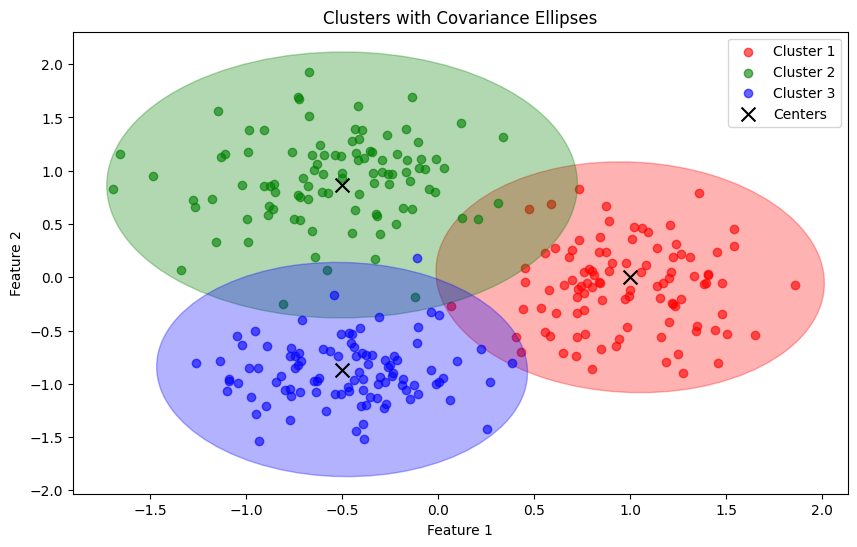

In [32]:
X_circle, yA_c, yB_c, labels_c, centers_c, covs_c = generate_data(
    center_generation='circle',
    # max_radius=1.0,
    # random_state=42,
    # cov_scales=(0.1, 0.2)
)
plot_clusters(X_circle, labels_c, centers_c, covs_c)

### Функции данных и откликов

In [33]:
def mk_clusters():
    X_circle, yA_c, yB_c, labels_c, centers_c, covs_c = generate_data(
        center_generation='circle',
        # max_radius=1.0,
        # random_state=42,
        # cov_scales=(0.1, 0.2)
    )
    return X_circle, yA_c

def clusters_y_A(y_cl):
    return y_cl

def clusters_y_B(X, y_cl, y_A):
    return y_cl ** 2

### Визуализация зависимости y_B от y_A

In [34]:
clusters_datasets = [
    ('Clusters', mk_clusters, clusters_y_A, clusters_y_B),
]

[('Clusters', <function mk_clusters at 0x000001CB6CFC7010>, <function clusters_y_A at 0x000001CB7D1BF010>, <function clusters_y_B at 0x000001CB7C765B40>)]


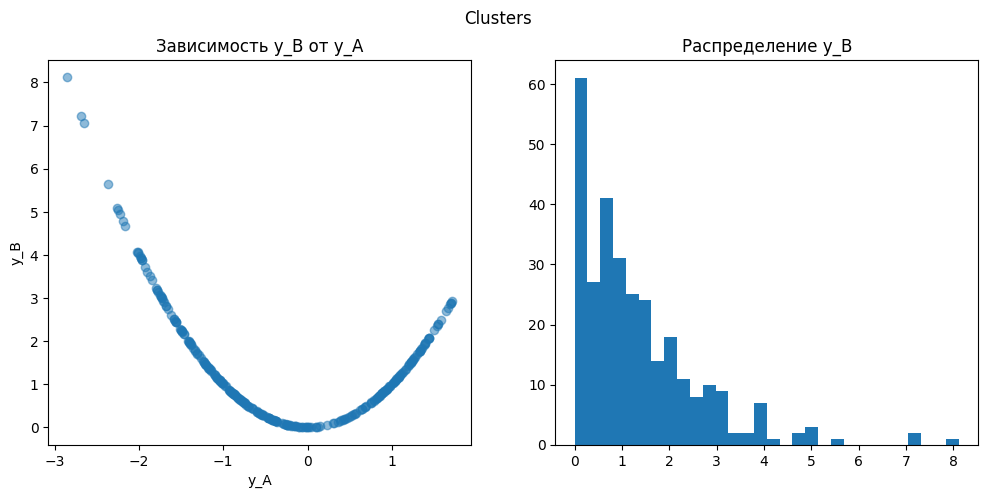

In [35]:
test_correlation(clusters_datasets)

### Результаты

In [36]:
for file in os.listdir(folder):
    if file.startswith(('Clusters')):
        name = file.split('.')[0].split('_')[0]
        df = pd.read_csv(Path(folder) / file, header=[0, 1])
        show_regression_results(name, df)

Clusters:
